# Decision Mining in Triage Processes Using Decision Tree Classification
A Data-Driven Approach to Analyze and Model Decision Points (DPs) in Triage Room Process.

## Initial Setup

In [26]:
# Import the necessary libraries

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier                 # To create and train Decision Tree models
from sklearn.model_selection import train_test_split            # To split data into training and test sets
from sklearn.metrics import accuracy_score, precision_score, recall_score         # For specific classification metrics
from sklearn.tree import export_graphviz                        # To export the decision tree in DOT format
from io import StringIO                                         # To handle string-based I/O for graph rendering
from IPython.display import Image                               # To display images in Jupyter notebooks
import pydotplus                                                # To convert DOT data to image
from sklearn.tree import _tree                                  # For extracting text rules from Decision Trees
from sklearn.tree import export_text                            # To extract human-readable decision rules


In [27]:
# Load the labeled triage event log

tiarge = pd.read_csv("labeled_triage_eventlog.csv")
display(tiarge.head(10))

,Case ID,Activity,Activity Label,time:timestamp,Heart_Rate,Oxygen_Saturation,Blood_Pressure,Age,Consciousness_Level,PHI,...,DP4_label,bp_sys,bp_dia,cons_num,PHI_num,Img_res_num,DP1_label_num,DP2_label_num,DP3_label_num,DP4_label_num
0,202501011,A,Initial Assessment,2025-01-01 10:26:00,63,87.7,128/52,51,Drowsy,Critical,...,H,128,52,1,1,NaN,0,3,1,0.0
1,202501011,B,Immediate CPR,2025-01-01 10:44:00,63,87.7,128/52,51,Drowsy,Critical,...,H,128,52,1,1,NaN,0,3,1,0.0
2,202501011,C,Stabilization and Monitoring,2025-01-01 11:11:00,63,87.7,128/52,51,Drowsy,Critical,...,H,128,52,1,1,NaN,0,3,1,0.0
3,202501011,E,Further Diagnostics and Imaging,2025-01-01 12:07:00,63,87.7,128/52,51,Drowsy,Critical,...,H,128,52,1,1,0.0,0,3,1,0.0
4,202501011,G,Treatment and Monitor Conditions,2025-01-01 12:19:00,63,87.7,128/52,51,Drowsy,Critical,...,H,128,52,1,1,0.0,0,3,1,0.0
5,202501011,H,Transfer to the ICU,2025-01-01 13:12:00,63,87.7,128/52,51,Drowsy,Critical,...,H,128,52,1,1,0.0,0,3,1,0.0
6,202501012,A,Initial Assessment,2025-01-01 08:49:00,133,89.9,103/51,47,Drowsy,Critical,...,NaN,103,51,1,1,NaN,0,3,0,NaN
7,202501012,B,Immediate CPR,2025-01-01 09:47:00,133,89.9,103/51,47,Drowsy,Critical,...,NaN,103,51,1,1,NaN,0,3,0,NaN
8,202501012,C,Stabilization and Monitoring,2025-01-01 10:17:00,133,89.9,103/51,47,Drowsy,Critical,...,NaN,103,51,1,1,NaN,0,3,0,NaN
9,202501012,E,Further Diagnostics and Imaging,2025-01-01 10:51:00,133,89.9,103/51,47,Drowsy,Critical,...,NaN,103,51,1,1,1.0,0,3,0,NaN


### Define feature sets

In [28]:
# feature set with only the Patient Health Indicator (PHI)
feature_cols_PHI = ['PHI_num']

# feature set with PHI and Imaging Results
feature_cols_PHI_Img = ['PHI_num','Img_res_num']

# feature set with 5 physiological attributes
feature_cols_5_Attribute = ['Heart_Rate', 'Oxygen_Saturation', 'bp_sys', 'bp_dia', 'Age', 'cons_num']

# feature set with the 5 physiological attributes and Imaging Results
feature_cols_5_Attribute_Img = ['Heart_Rate', 'Oxygen_Saturation', 'bp_sys', 'bp_dia', 'Age', 'cons_num', 'Img_res_num']

## Decision Mining Using Decision Tree Classifier
This section applies decision tree models to uncover decision logic at DPs in the triage process.

### DP1 – Decision Tree Modeling for Decision Point 1

In [29]:
# Load the labeled triage event log specific to DP1

dp_DP1_eventlog_tiarge = pd.read_csv("DP1_labeled_triage_eventlog.csv")
display(dp_DP1_eventlog_tiarge.head(10))

,Case ID,Activity,Heart_Rate,Oxygen_Saturation,bp_sys,bp_dia,Age,cons_num,PHI_num,DP1_label_num
0,202501011,A,63,87.7,128,52,51,1,1,0
1,202501012,A,133,89.9,103,51,47,1,1,0
2,202501013,A,100,83.7,83,46,75,0,0,0
3,202501014,A,136,86.1,81,50,30,1,1,0
4,202501015,A,108,88.3,104,69,18,1,1,0
5,202501016,A,102,79.7,115,69,26,0,0,0
6,202501017,A,121,76.6,103,49,44,0,0,0
7,202501018,A,111,90.1,117,55,56,2,2,1
8,202501019,A,112,82.0,83,54,41,0,0,0
9,2025010110,A,97,87.0,83,68,46,1,1,0


In [30]:
# Select input features (X) and target variable (y) for DP1

X1 = dp_DP1_eventlog_tiarge[feature_cols_PHI] # Features: only 'PHI_num'
y1 = dp_DP1_eventlog_tiarge.DP1_label_num     # Target variable: the label for DP1

# Split the dataset into training and testing sets (70% train, 30% test)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=1)

# Create a Decision Tree Classifier object
clf1 = DecisionTreeClassifier()

# Train the classifier on the training data
clf1 = clf1.fit(X_train1,y_train1)

# Predict the target values for the test data
y_pred1 = clf1.predict(X_test1)

# Evaluate model performance using accuracy, precision, and recall
accuracy = accuracy_score(y_test1, y_pred1)  
precision = precision_score(y_test1, y_pred1, average='weighted', zero_division=0)  
recall = recall_score(y_test1, y_pred1, average='weighted', zero_division=0)  

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


In [31]:
# # Check data types of feature columns in the training set
# print(X_train1.dtypes)

# # Check data type of the target variable
# print(y_train1.dtypes)

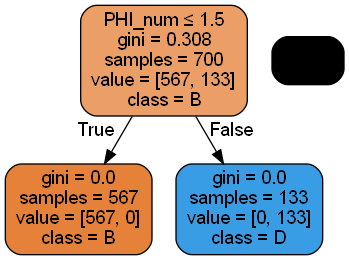

In [32]:
# Step 1: Create class_names dynamically based on the unique classes in y_train1
# This ensures the tree visualization reflects the actual class labels
class_names = [str(cls) for cls in np.unique(y_train1)]

# Step 2: Export the trained decision tree to DOT format
dot_data = StringIO()
export_graphviz(clf1,                      # The trained DecisionTreeClassifier
                out_file=dot_data,         # Where to store the DOT data
                filled=True,               # Fill the nodes with color
                rounded=True,              # Rounded node corners
                special_characters=True,   # Allow special characters
                feature_names=feature_cols_PHI,       # Names of the features used in X1
                class_names=['B', 'D'])               # generate class labels

# Step 3: Generate and save the decision tree image from DOT data
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree_DP1.png') 

Image(graph.create_png())

In [80]:
# Export the textual rules from the trained decision tree (clf1)
rules_text = export_text(clf1, feature_names=feature_cols_PHI)
print(rules_text)

|--- PHI_num <= 1.50
|   |--- class: 0
|--- PHI_num >  1.50
|   |--- class: 1



In [76]:
# Helper function to auto-generate feature names for the decision tree
def _safe_feature_names(clf, feature_names):
    n = getattr(clf, "n_features_in_", None)
    if n is None:
        return feature_names
    # If no feature names are provided or the length doesn't match, generate generic f0, f1, ...
    if feature_names is None or len(feature_names) != n:
        return [f"f{i}" for i in range(n)]
    return list(feature_names)

# Helper function to simplify path conditions into textual rules
def _simplify_guard(conds, decimals=3):
    import math
    bounds = {}
    # Iterate through conditions and compute lower/upper bounds for each feature
    for f, op, t in conds:
        d = bounds.setdefault(f, {"lb": -math.inf, "ub": math.inf})
        if op == "<=":
            d["ub"] = min(d["ub"], float(t))
        elif op == ">":
            d["lb"] = max(d["lb"], float(t))
    # Convert bounds into readable conditions
    parts = []
    for f, d in bounds.items():
        lb, ub = d["lb"], d["ub"]
        if lb == -math.inf and ub == math.inf:
            continue
        if lb == -math.inf:
            parts.append(f"{f} <= {round(ub, decimals)}")
        elif ub == math.inf:
            parts.append(f"{f} > {round(lb, decimals)}")
        else:
            parts.append(f"{f} > {round(lb, decimals)} and {f} <= {round(ub, decimals)}")
    return parts

# Main function: print decision rules for each class in a DecisionTreeClassifier
def simple_rules_text(clf, feature_names=None, class_names=None, decimals=3, print_empty_classes=False):

    feature_names = _safe_feature_names(clf, feature_names)     # Ensure feature names are valid
    tree_ = clf.tree_
    feat = tree_.feature
    thr = tree_.threshold
    left = tree_.children_left
    right = tree_.children_right

# Map numerical class indices to human-readable class labels if provided
    classes = list(clf.classes_)
    if class_names is not None and len(class_names) == len(classes):
        cls_map = {classes[i]: class_names[i] for i in range(len(classes))}
    else:
        cls_map = {c: str(c) for c in classes}

    per_class = {cls_map[c]: [] for c in classes}            # Store rules per class
    path = []                                                # Keep track of the current path (conditions)

# Depth-first search through the tree to collect rules
    def dfs(node):
        if feat[node] != _tree.TREE_UNDEFINED:
            fname = feature_names[feat[node]]
            t = round(float(thr[node]), decimals)
            # Left branch: <= threshold
            path.append((fname, "<=", t))
            dfs(left[node])
            path.pop()
            # Right branch: > threshold
            path.append((fname, ">", t))
            dfs(right[node])
            path.pop()
        else:
            # At a leaf: assign the rule path to the predicted class
            counts = tree_.value[node][0]
            pred_idx = counts.argmax()
            pred_class = classes[pred_idx]
            pred_lbl = cls_map[pred_class]
            simplified_parts = _simplify_guard(path, decimals=decimals)
            guard_text = " and ".join(simplified_parts) if simplified_parts else "True"
            per_class[pred_lbl].append(guard_text)

    dfs(0)

    # Print the collected rules for each class
    for c, guards in per_class.items():
        if not guards and not print_empty_classes:
            continue
        expr = " OR ".join(f"({g})" for g in guards) if guards else "False"
        print(f"class = {c}: {expr}")


In [82]:
# DP1: Extract and print decision rules
# Generate rules from the trained decision tree (clf1) using PHI_num as feature
print("Rules for DP1")
simple_rules_text(clf1, feature_names=feature_cols_PHI, class_names=['B', 'D'], print_empty_classes=False)

# Print a separator line for readability
print("-"*80)

Rules for DP1
class = B: (PHI_num <= 1.5)
class = D: (PHI_num > 1.5)
--------------------------------------------------------------------------------


### DP2 – Decision Tree Modeling for Decision Point 2

In [36]:
# Load the labeled triage event log specific to DP2

dp_DP2_eventlog_tiarge = pd.read_csv("DP2_labeled_triage_eventlog.csv")
display(dp_DP2_eventlog_tiarge.head(10))

,Case ID,Activity,Heart_Rate,Oxygen_Saturation,bp_sys,bp_dia,Age,cons_num,PHI_num,DP2_label_num
0,202501011,A,63,87.7,128,52,51,1,1,3
1,202501011,B,63,87.7,128,52,51,1,1,3
2,202501011,C,63,87.7,128,52,51,1,1,3
3,202501012,A,133,89.9,103,51,47,1,1,3
4,202501012,B,133,89.9,103,51,47,1,1,3
5,202501012,C,133,89.9,103,51,47,1,1,3
6,202501013,A,100,83.7,83,46,75,0,0,0
7,202501013,B,100,83.7,83,46,75,0,0,0
8,202501013,C,100,83.7,83,46,75,0,0,0
9,202501013,B,100,83.7,83,46,75,0,0,0


In [37]:
# Select input features (X) and target variable (y) for DP2
X2 = dp_DP2_eventlog_tiarge[feature_cols_PHI]           # Features: here using only 'PHI_num'
y2 = dp_DP2_eventlog_tiarge.DP2_label_num               # Target variable for DP2

# Split the dataset into training and testing sets (70% train, 30% test)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=1) # 70% training and 30% test

# Create a Decision Tree Classifier object
clf2 = DecisionTreeClassifier()

# Train the classifier on the training data
clf2 = clf2.fit(X_train2,y_train2)

# Predict the target values for the test data
y_pred2 = clf2.predict(X_test2)

# Evaluate model performance using accuracy, precision, and recall
accuracy = accuracy_score(y_test2, y_pred2)
precision = precision_score(y_test2, y_pred2, average='weighted', zero_division=0)
recall = recall_score(y_test2, y_pred2, average='weighted', zero_division=0)

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8590604026845637
Precision: 0.7381346272234878
Recall: 0.8590604026845637


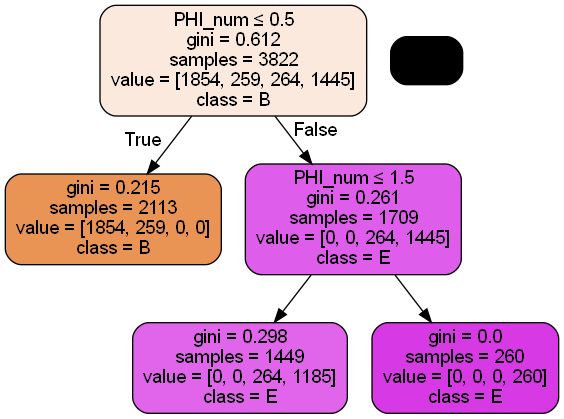

In [38]:
# Step 1: Create class_names dynamically based on the unique classes in y_train2
# Ensures the tree uses correct class labels for visualization
class_names = [str(cls) for cls in np.unique(y_train2)]

# Step 2: Export the trained decision tree to DOT format
dot_data = StringIO()
export_graphviz(clf2,                                 # Trained Decision Tree Classifier for DP2
                out_file=dot_data,                    # Output stream to hold DOT data
                filled=True,                          # Fill nodes with color
                rounded=True,                         # Use rounded boxes for nodes
                special_characters=True,              # Enable special characters in labels
                feature_names=feature_cols_PHI,       # Feature names used in X2
                class_names=['B', 'C', 'D', 'E'])    # Explicit class labels for the nodes (adjust based on your actual labels)

# Step 3: Generate and save the decision tree as a PNG image
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree_DP2.png')

Image(graph.create_png())

In [84]:
# Export the textual rules from the trained decision tree (clf2)
rules_text = export_text(clf2, feature_names=feature_cols_PHI)
print(rules_text)

|--- PHI_num <= 0.50
|   |--- class: 0
|--- PHI_num >  0.50
|   |--- PHI_num <= 1.50
|   |   |--- class: 3
|   |--- PHI_num >  1.50
|   |   |--- class: 3



In [86]:
# DP2: Extract and print decision rules
# Generate rules from the trained decision tree (clf2) using PHI_num as feature
print("Rules for DP2")
simple_rules_text(clf2, feature_names=feature_cols_PHI, class_names=['B', 'C', 'D', 'E'], print_empty_classes=False)

# Print a separator line for readability
print("-"*80)

Rules for DP2
class = B: (PHI_num <= 0.5)
class = E: (PHI_num > 0.5 and PHI_num <= 1.5) OR (PHI_num > 1.5)
--------------------------------------------------------------------------------


### DP3 – Decision Tree Modeling for Decision Point 3

In [41]:
# Load the labeled triage event log specific to DP3

dp_DP3_eventlog_tiarge = pd.read_csv("DP3_labeled_triage_eventlog.csv")
display(dp_DP3_eventlog_tiarge.head(10))

,Case ID,Activity,Heart_Rate,Oxygen_Saturation,bp_sys,bp_dia,Age,cons_num,PHI_num,Img_res_num,DP3_label_num
0,202501011,A,63,87.7,128,52,51,1,1,0,1
1,202501011,B,63,87.7,128,52,51,1,1,0,1
2,202501011,C,63,87.7,128,52,51,1,1,0,1
3,202501011,E,63,87.7,128,52,51,1,1,0,1
4,202501012,A,133,89.9,103,51,47,1,1,1,0
5,202501012,B,133,89.9,103,51,47,1,1,1,0
6,202501012,C,133,89.9,103,51,47,1,1,1,0
7,202501012,E,133,89.9,103,51,47,1,1,1,0
8,202501013,A,100,83.7,83,46,75,0,0,0,1
9,202501013,B,100,83.7,83,46,75,0,0,0,1


In [87]:
# Select input features (X) and target variable (y) for DP3
X3 = dp_DP3_eventlog_tiarge[feature_cols_PHI_Img]     # Features: includes PHI_num and Img_res_num
y3 = dp_DP3_eventlog_tiarge.DP3_label_num             # Target variable for DP33


# Split the dataset into training and testing sets (70% training, 30% testing)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=1) # 70% training and 30% test

# Create a Decision Tree Classifier object
clf3 = DecisionTreeClassifier()

# Train the classifier on the training data
clf3 = clf3.fit(X_train3,y_train3)

# Predict the target values for the test data
y_pred3 = clf3.predict(X_test3)

# Evaluate model performance using accuracy, precision, and recall
accuracy = accuracy_score(y_test3, y_pred3)
precision = precision_score(y_test3, y_pred3, average='weighted', zero_division=0)
recall = recall_score(y_test3, y_pred3, average='weighted', zero_division=0)

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


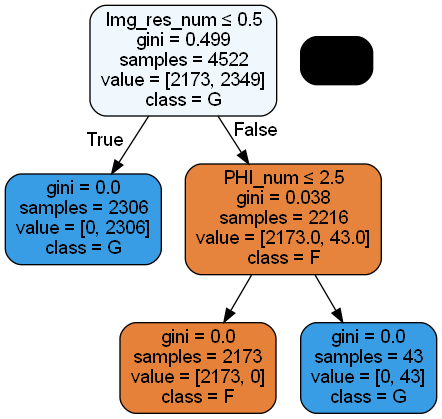

In [89]:
# Step 1: Create class_names dynamically based on the unique classes in y_train3
# This ensures the correct class labels are shown in the visualization
class_names = [str(cls) for cls in np.unique(y_train3)]

# Step 2: Export the trained decision tree to DOT format
dot_data = StringIO()
export_graphviz(clf3,                       # Trained DecisionTreeClassifier for DP3
                out_file=dot_data,          # Output stream for DOT data      
                filled=True,                # Fill node colors based on class
                rounded=True,               # Use rounded box shapes for nodes
                special_characters=True,    # Allow special characters in labels
                feature_names=feature_cols_PHI_Img,      # Feature names used (PHI_num and Img_res_num)
                class_names=['F', 'G'])                  # Human-readable class names (adjust if necessary)

# Step 3: Generate and save the decision tree image from DOT data
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree_DP3.png') 

Image(graph.create_png())

In [44]:
# Export the textual rules from the trained decision tree (clf3)
rules_text = export_text(clf3, feature_names=feature_cols_PHI_Img)
print(rules_text)

|--- Img_res_num <= 0.50
|   |--- class: 1
|--- Img_res_num >  0.50
|   |--- PHI_num <= 2.50
|   |   |--- class: 0
|   |--- PHI_num >  2.50
|   |   |--- class: 1



In [45]:
# DP3: Extract and print decision rules
# Generate rules from the trained decision tree (clf5) using PHI_num as feature
print("Rules for DP3")
simple_rules_text(clf3, feature_names=feature_cols_PHI_Img, class_names=['F', 'G'], print_empty_classes=False)

# Print a separator line for readability
print("-"*80)

Rules for DP3
class = F: (Img_res_num > 0.5 and PHI_num <= 2.5)
class = G: (Img_res_num <= 0.5) OR (Img_res_num > 0.5 and PHI_num > 2.5)
--------------------------------------------------------------------------------


### DP4 – Decision Tree Modeling for Decision Point 4

In [46]:
# Load the labeled triage event log specific to DP4

dp_DP4_eventlog_tiarge = pd.read_csv("DP4_labeled_triage_eventlog.csv")
display(dp_DP4_eventlog_tiarge.head(10))

,Case ID,Activity,Heart_Rate,Oxygen_Saturation,bp_sys,bp_dia,Age,cons_num,PHI_num,Img_res_num,DP4_label_num
0,202501011,A,63,87.7,128,52,51,1,1,0,0
1,202501011,B,63,87.7,128,52,51,1,1,0,0
2,202501011,C,63,87.7,128,52,51,1,1,0,0
3,202501011,E,63,87.7,128,52,51,1,1,0,0
4,202501011,G,63,87.7,128,52,51,1,1,0,0
5,202501013,A,100,83.7,83,46,75,0,0,0,0
6,202501013,B,100,83.7,83,46,75,0,0,0,0
7,202501013,C,100,83.7,83,46,75,0,0,0,0
8,202501013,B,100,83.7,83,46,75,0,0,0,0
9,202501013,C,100,83.7,83,46,75,0,0,0,0


In [47]:
# Select input features (X) and target variable (y) for DP4
X4 = dp_DP4_eventlog_tiarge[feature_cols_PHI_Img]          # Features: includes PHI_num and Img_res_num
y4 = dp_DP4_eventlog_tiarge.DP4_label_num                  # Target variable for DP4


# Split the dataset into training and testing sets (70% training, 30% testing)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state=1)

# Create a Decision Tree Classifier object
clf4 = DecisionTreeClassifier()

# Train the classifier on the training data
clf4 = clf4.fit(X_train4,y_train4)

# Predict the target values for the test data
y_pred4 = clf4.predict(X_test4)

# Evaluate model performance using accuracy, precision, and recall
accuracy = accuracy_score(y_test4, y_pred4)
precision = precision_score(y_test4, y_pred4, average='weighted', zero_division=0)
recall = recall_score(y_test4, y_pred4, average='weighted', zero_division=0)

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


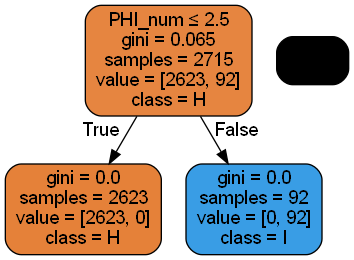

In [48]:
# Step 1: Create class_names dynamically based on the unique classes in y_train4
# This ensures that class labels shown in the tree match the actual labels
class_names = [str(cls) for cls in np.unique(y_train4)]

# Step 2: Export the trained decision tree to DOT format
dot_data = StringIO()
export_graphviz(clf4,                         # Trained DecisionTreeClassifier for DP4
                out_file=dot_data,            # StringIO object to hold DOT data
                filled=True,                  # Fill the nodes with class-specific colors
                rounded=True,                 # Use rounded box corners for better readability
                special_characters=True,      # Support for special characters in node labels
                feature_names=feature_cols_PHI_Img,     # Feature names used for training (PHI_num + Img_res_num)
                class_names=['H', 'I'])                  # Human-readable class names (adjust if necessary)

# Step 3: Generate and save the decision tree as a PNG image
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree_DP4.png') 

Image(graph.create_png())

In [49]:
# Export the textual rules from the trained decision tree (clf4)
rules_text = export_text(clf4, feature_names=feature_cols_PHI_Img)
print(rules_text)

|--- PHI_num <= 2.50
|   |--- class: 0
|--- PHI_num >  2.50
|   |--- class: 1



In [50]:
# DP4: Extract and print decision rules
# Generate rules from the trained decision tree (clf4) using PHI_num as feature
print("Rules for DP4")
simple_rules_text(clf4, feature_names=feature_cols_PHI_Img, class_names=['H', 'I'], print_empty_classes=False)

# Print a separator line for readability
print("-"*80)

Rules for DP4
class = H: (PHI_num <= 2.5)
class = I: (PHI_num > 2.5)
--------------------------------------------------------------------------------
